Drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [2]:
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization


# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

Dataset

In [3]:
BATCH_SIZE = 64
EPOCHS = 10

TRAIN_PATH = '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/train/'
TEST_PATH = '/content/drive/MyDrive/chestxraydataset/xray_dataset_covid19/test/'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

In [4]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal)
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')
print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  74
Pneumonia images in train-set:  74
Total images in train-set:  148 ---> 78.7 Percent

Normal images in test-set: 20
Pneumonia images in test-set: 20
Total images in test-set:  40 ---> 21.3 Percent

All the images in Dataset:  188


In [5]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0.
                                   samplewise_std_normalization=True) # Divide each input by its std.

train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')
validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 120 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


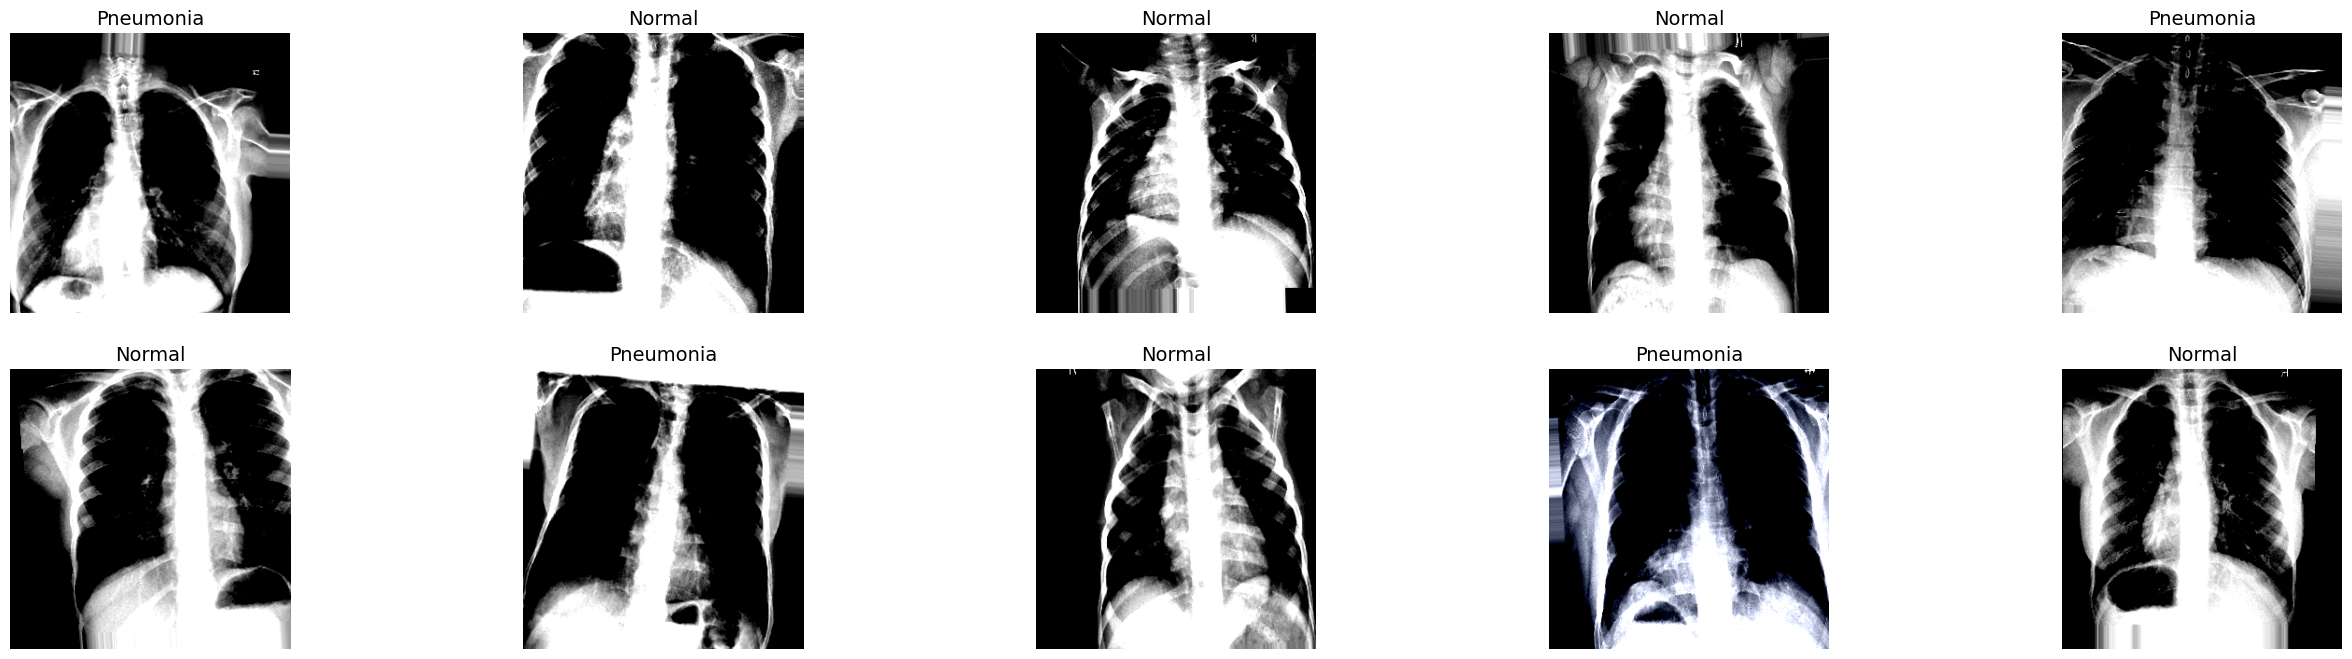

In [6]:
def show_tarin(batch_size, images, labels):

    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]

    image_rows = 2
    image_col = int(batch_size/image_rows)

    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()

    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
show_tarin(10, image_train, label_train)

In [7]:
def craete_model():

    # Load v3 model without the top layer
    inception_v3_model = InceptionV3(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)

    # Freeze
    inception_v3_model.trainable = False

    # New classifier layers
    flatten = Flatten()(inception_v3_model.layers[-1].output) # Flatt last v3 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)

    # Define a new Model
    model = Model(inputs=inception_v3_model.input, outputs=output)
    model.summary()

    return model


model = craete_model()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [8]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [9]:
history = model.fit(train_generator, # If x is a dataset -> y should not be specified (since targets will be obtained from x).
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    verbose=1)

print('\n*** Fit is over ***')

Epoch 1/10
2/2 [==============================] - 94s 43s/step - loss: 1.0927 - accuracy: 0.5417 - val_loss: 1.0655 - val_accuracy: 0.5714
Epoch 2/10
2/2 [==============================] - 45s 24s/step - loss: 0.6771 - accuracy: 0.7083 - val_loss: 0.6554 - val_accuracy: 0.6071
Epoch 3/10
2/2 [==============================] - 46s 26s/step - loss: 0.2256 - accuracy: 0.9250 - val_loss: 0.2284 - val_accuracy: 0.8929
Epoch 4/10
2/2 [==============================] - 48s 23s/step - loss: 0.2218 - accuracy: 0.8917 - val_loss: 0.2531 - val_accuracy: 0.8571
Epoch 5/10
2/2 [==============================] - 45s 24s/step - loss: 0.1689 - accuracy: 0.9250 - val_loss: 0.1854 - val_accuracy: 0.9643
Epoch 6/10
2/2 [==============================] - 45s 24s/step - loss: 0.1079 - accuracy: 0.9667 - val_loss: 0.1852 - val_accuracy: 0.9286
Epoch 7/10
2/2 [==============================] - 46s 23s/step - loss: 0.1479 - accuracy: 0.9250 - val_loss: 0.1107 - val_accuracy: 0.9643
Epoch 8/10
2/2 [===========

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)


print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  0.149468
Test Accuracy:  90.0 %


In [10]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)


print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  0.189156
Test Accuracy:  92.5 %


1/1 [==============================] - 2s 2s/step


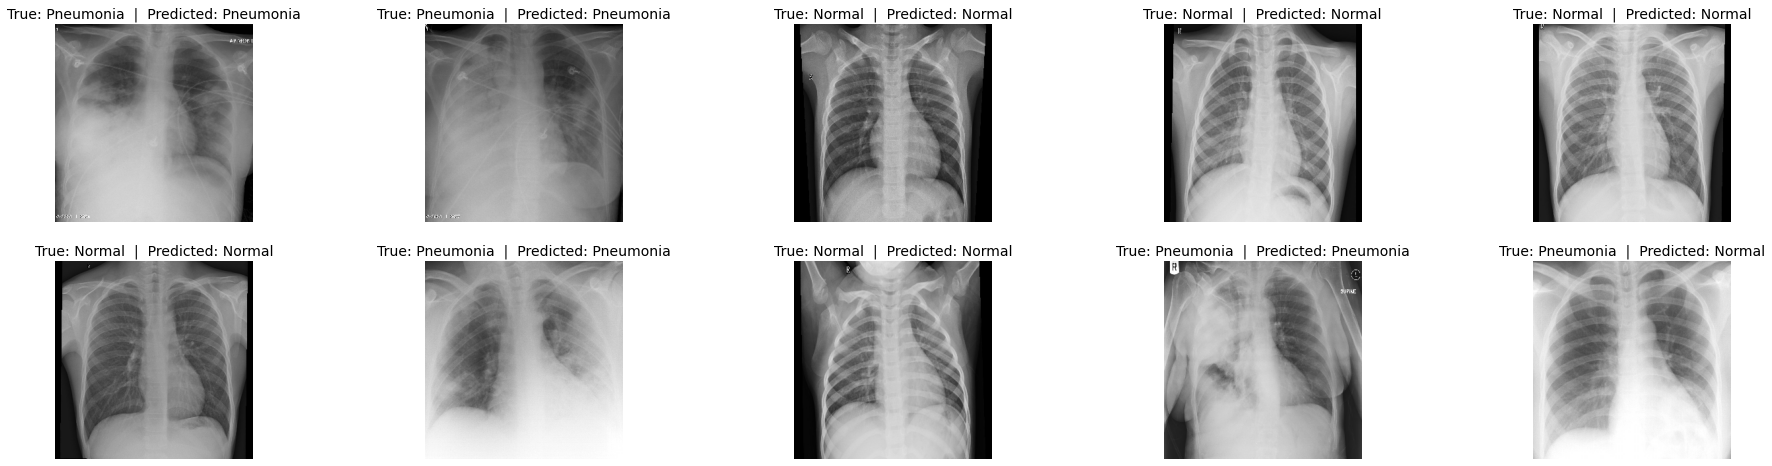

In [ ]:
def show(model, batch_size, images, labels):

    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))

    image_rows = 2
    image_col = int(batch_size/image_rows)

    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()

    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()


show(model, 10, image_test, label_test)

In [ ]:
from keras.models import load_model

model.save('my_model.h5')